**Import Packages**

In [36]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

**Prepare dataset**

In [2]:
num_classes = 10

In [3]:
train_set, test_set = tf.keras.datasets.mnist.load_data()

x_train_0 = train_set[0].astype("float32") / 255
x_train_0 = np.expand_dims(x_train_0, -1)
y_train_0 = tf.one_hot(train_set[1], num_classes)

x_test = test_set[0].astype("float32") / 255
x_test = np.expand_dims(x_test, -1)
y_test = tf.one_hot(test_set[1], num_classes)

print(x_train_0.shape, x_test.shape)
print(y_train_0.shape, y_test.shape)

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1) (10000, 28, 28, 1)
(60000, 10) (10000, 10)


**Hyperparameters**

In [47]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 64
epochs = 15

**Convert data into TensorFlow Dataset objects**

In [48]:
val_size = 5000

x_val, y_val = x_train_0[:val_size], y_train_0[:val_size]
x_train, y_train = x_train_0[val_size:], y_train_0[val_size:] 

train_ds_1 = (
    tf.data.Dataset.from_tensor_slices((x_train,y_train))
    .shuffle(batch_size*100)
    .batch(batch_size)
)

train_ds_2 = (
    tf.data.Dataset.from_tensor_slices((x_train,y_train))
    .shuffle(batch_size*100)
    .batch(batch_size)
)

# Mixing up 2 train_dataset by combining 2 shuffled datasets
train_ds = tf.data.Dataset.zip((train_ds_1, train_ds_2))
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

In [31]:
count = 0
for element in train_ds:
  count +=1
print(count)

860


**Define the MixUp technique function**

`new_x = lambda * x1 + (1 - lambda) * x2 (where x1 and x2 are images)`

In [34]:
def beta_distribution(shape, concentration_1, concentration_2):
  gamma_1 = tf.random.gamma(shape=[shape], alpha=concentration_1)
  gamma_2 = tf.random.gamma(shape=[shape], alpha=concentration_2)

  return gamma_1 / (gamma_1 + gamma_2)

def mix_up(ds_1, ds_2, alpha=0.2):
  # Unpack datasets
  images_1, labels_1 = ds_1
  images_2, labels_2 = ds_2
  batch_size = tf.shape(images_1)[0]

  sample = beta_distribution(batch_size, alpha, alpha)
  x_sample = tf.reshape(sample, (batch_size, 1, 1, 1))
  y_sample = tf.reshape(sample, (batch_size,1))

  images = images_1*x_sample + images_2*(1-x_sample)
  labels = labels_1*y_sample + labels_2*(1-y_sample)

  return (images, labels)

**Visualize augmented data**

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.23776352405548096, 0.762236475944519]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.006525218486785889, 0.9934747815132141, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.008887882344424725, 0.0, 0.0, 0.0, 0.0, 0.9911121129989624]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
[0.0, 0.9648013114929199, 0.0, 0.0, 0.0, 0.0, 0.03519866615533829, 0.0, 0.0, 0.0]
[0.0, 0.2415054440498352, 0.7584945559501648, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
[0.0, 0.0, 0.0, 0.0, 0.6011260747909546, 0.0, 0.3988739252090454, 0.0, 0.0, 0.0]
[0.9999998807907104, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3575507296081923e-07, 0.0, 0.0, 0.0]


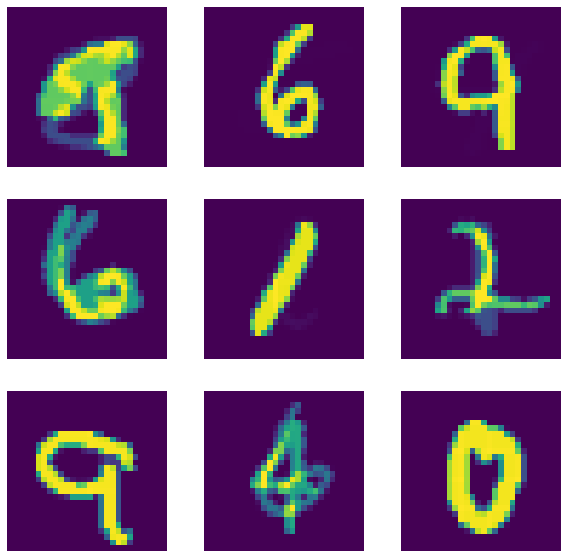

In [35]:
train_ds_mixed = train_ds.map(
    lambda ds_1, ds_2 : mix_up(ds_1, ds_2, alpha=0.2), num_parallel_calls = AUTOTUNE
)

sample_images, sample_labels = next(iter(train_ds_mixed))

plt.figure(figsize =(10,10))
for i, (image, label) in enumerate(zip(sample_images[:9], sample_labels[:9])):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image.numpy().squeeze())
  print(label.numpy().tolist())
  plt.axis("off")

**Build Model**

In [39]:
def build_model():
  model = keras.Sequential([
          keras.Input(shape = (28,28,1)),
          layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
          layers.MaxPooling2D(pool_size=(2, 2)),
          layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
          layers.MaxPooling2D(pool_size=(2, 2)),
          layers.Dropout(0.2),
          layers.GlobalAvgPool2D(),
          layers.Dense(128, activation="relu"),
          layers.Dense(num_classes, activation="softmax")
  ])

  return model

We save the initial random weights to compare model with mixed up data and model with initial data

In [40]:
initial_model = build_model()
initial_model.save_weights("initial_weights.h5")

**Train model with the mixed up data**

In [41]:
model = build_model()
model.load_weights("initial_weights.h5")
model.compile(loss = "categorical_crossentropy", optimizer="adam", metrics = ["accuracy"])
history = model.fit(train_ds_mixed, validation_data=val_ds, epochs= epochs)

Epoch 1/15
860/860 [==============================] - 20s 8ms/step - loss: 1.3116 - accuracy: 0.6076 - val_loss: 0.5112 - val_accuracy: 0.8606
Epoch 2/15
860/860 [==============================] - 7s 8ms/step - loss: 0.8240 - accuracy: 0.8190 - val_loss: 0.3920 - val_accuracy: 0.8884
Epoch 3/15
860/860 [==============================] - 7s 8ms/step - loss: 0.7147 - accuracy: 0.8610 - val_loss: 0.2797 - val_accuracy: 0.9248
Epoch 4/15
860/860 [==============================] - 8s 9ms/step - loss: 0.6610 - accuracy: 0.8811 - val_loss: 0.2102 - val_accuracy: 0.9514
Epoch 5/15
860/860 [==============================] - 7s 8ms/step - loss: 0.6183 - accuracy: 0.8949 - val_loss: 0.1869 - val_accuracy: 0.9580
Epoch 6/15
860/860 [==============================] - 7s 8ms/step - loss: 0.6001 - accuracy: 0.9023 - val_loss: 0.1660 - val_accuracy: 0.9588
Epoch 7/15
860/860 [==============================] - 7s 9ms/step - loss: 0.5698 - accuracy: 0.9113 - val_loss: 0.1503 - val_accuracy: 0.9652
Epoch

<Figure size 432x288 with 0 Axes>

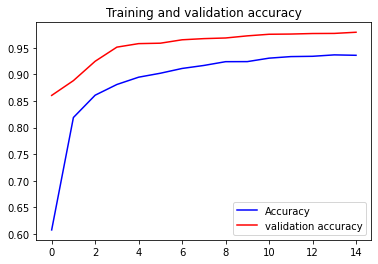

<Figure size 432x288 with 0 Axes>

In [46]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

e = range(len(accuracy))

# Plot training and validation accuracy
plt.plot(e, accuracy,color='blue')
plt.plot(e, val_accuracy, color = 'red')
plt.legend(['Accuracy', 'validation accuracy'])
plt.title ('Training and validation accuracy')
plt.figure()

In [43]:
_, test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

157/157 [==============================] - 1s 5ms/step - loss: 0.0878 - accuracy: 0.9803
Test accuracy: 98.03%


**Train model with original data**

In [49]:
model = build_model()
model.load_weights("initial_weights.h5")
model.compile(loss = "categorical_crossentropy", optimizer="adam", metrics = ["accuracy"])
history = model.fit(train_ds_1, validation_data=val_ds, epochs= epochs)

Epoch 1/15
860/860 [==============================] - 7s 8ms/step - loss: 1.0213 - accuracy: 0.6569 - val_loss: 0.4589 - val_accuracy: 0.8686
Epoch 2/15
860/860 [==============================] - 7s 8ms/step - loss: 0.4362 - accuracy: 0.8646 - val_loss: 0.2865 - val_accuracy: 0.9212
Epoch 3/15
860/860 [==============================] - 8s 10ms/step - loss: 0.3270 - accuracy: 0.8973 - val_loss: 0.2345 - val_accuracy: 0.9342
Epoch 4/15
860/860 [==============================] - 9s 10ms/step - loss: 0.2701 - accuracy: 0.9156 - val_loss: 0.1994 - val_accuracy: 0.9408
Epoch 5/15
860/860 [==============================] - 9s 10ms/step - loss: 0.2360 - accuracy: 0.9258 - val_loss: 0.1684 - val_accuracy: 0.9488
Epoch 6/15
860/860 [==============================] - 7s 8ms/step - loss: 0.2151 - accuracy: 0.9334 - val_loss: 0.1590 - val_accuracy: 0.9516
Epoch 7/15
860/860 [==============================] - 7s 8ms/step - loss: 0.1911 - accuracy: 0.9408 - val_loss: 0.1365 - val_accuracy: 0.9610
Epo

<Figure size 432x288 with 0 Axes>

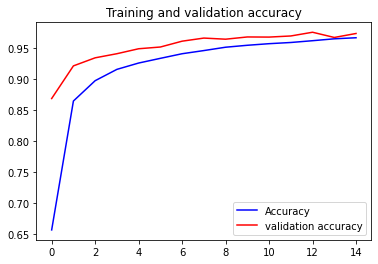

<Figure size 432x288 with 0 Axes>

In [50]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

e = range(len(accuracy))

# Plot training and validation accuracy
plt.plot(e, accuracy,color='blue')
plt.plot(e, val_accuracy, color = 'red')
plt.legend(['Accuracy', 'validation accuracy'])
plt.title ('Training and validation accuracy')
plt.figure()

In [51]:
_, test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

157/157 [==============================] - 1s 5ms/step - loss: 0.0879 - accuracy: 0.9739
Test accuracy: 97.39%
